In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#Used for month, day_of_week, hour_of_day, weekday and holiday

data = pd.read_csv("../Training/training_data_VT2026.csv")

# Make buinary variable for high bike demand:
# high_bike_demand -> 1
# low_bike_demand  -> 0
data["high_demand"] = (data["increase_stock"] == "high_bike_demand").astype(int)


# Share of high demand
weekday_high_rate = data.groupby("precip")["high_demand"].mean()


plt.figure(figsize=(10, 5))
plt.bar(weekday_high_rate.index, weekday_high_rate.values)

plt.xlabel("Weekday )")
plt.ylabel("Proportion of high bike demand")
plt.title("High bike demand depending on weekday or weekend")

plt.ylim(0, 1)
plt.xticks(range(0, 2))
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("demand_over_weekday.png", bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data["high_demand"] = (data["increase_stock"] == "high_bike_demand").astype(int)

# Binary rain-variable
data["rain"] = (data["precip"] > 0).astype(int)

summary = (
    data.groupby("rain")
    .agg(
        high_rate=("high_demand", "mean"),
        count=("high_demand", "size")
    )
)

plt.figure(figsize=(6, 4))
plt.bar(["No rain", "Rain"], summary["high_rate"])

plt.ylabel("Proportion of high bike demand")
plt.title("High bike demand on rainy vs non-rainy days")
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)

for i, n in enumerate(summary["count"]):
    plt.text(i, 0.02, f"n={n}", ha="center", fontsize=10)

plt.tight_layout()
plt.savefig("precip.png", bbox_inches="tight", pad_inches=0)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("../Training/training_data_VT2026.csv")
data["high_demand"] = (data["increase_stock"] == "high_bike_demand").astype(int)

# Binär snow-variable
data["snow_on_ground"] = (data["snowdepth"] > 0).astype(int)

summary = (
    data.groupby("snow_on_ground")
    .agg(
        high_rate=("high_demand", "mean"),
        count=("high_demand", "size")
    )
)

plt.figure(figsize=(6, 4))
plt.bar(["No snow", "Snow on ground"], summary["high_rate"])

plt.ylabel("Proportion of high bike demand")
plt.title("High bike demand with vs without snow on ground")
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)

for i, n in enumerate(summary["count"]):
    plt.text(i, 0.02, f"n={n}", ha="center", fontsize=10)

plt.tight_layout()
plt.savefig("snow_on_ground.png", bbox_inches="tight", pad_inches=0)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("../Training/training_data_VT2026.csv")
data["high_demand"] = (data["increase_stock"] == "high_bike_demand").astype(int)

# Define even bins for humidity
bins = np.arange(15, 100, 10)  # 15–95 i steg om 10
data["humidity_bin"] = pd.cut(data["humidity"], bins=bins)

summary = (
    data.groupby("humidity_bin")
    .agg(
        high_rate=("high_demand", "mean"),
        count=("high_demand", "size")
    )
)

plt.figure(figsize=(8, 4))
plt.bar(range(len(summary)), summary["high_rate"])

plt.xticks(
    range(len(summary)),
    [f"{int(b.left)}–{int(b.right)}" for b in summary.index],
)

plt.xlabel("Humidity (%)")
plt.ylabel("Proportion of high bike demand")
plt.title("High bike demand vs humidity")
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)

# Add count of observations above bars
for i, n in enumerate(summary["count"]):
    plt.text(i, 0.02, f"n={n}", ha="center", fontsize=9)

plt.tight_layout()
plt.savefig("humidity.png", bbox_inches="tight", pad_inches=0)
plt.show()


Peak runt 17-18 på kvällen!

Peak på lördagar! (och lite söndagar)

Peak Juni, april, september (oktober)

Inte jättestor skillnad på holiday eller ej

Större efterfrågan på helger!

=== BASELINE (otunad + class_weight) ===
Accuracy: 0.8625
Recall (high_bike_demand): 0.5504201680672269

Classification Report (Baseline):
                  precision    recall  f1-score   support

high_bike_demand       0.66      0.55      0.60       238
 low_bike_demand       0.90      0.93      0.92      1042

        accuracy                           0.86      1280
       macro avg       0.78      0.74      0.76      1280
    weighted avg       0.86      0.86      0.86      1280



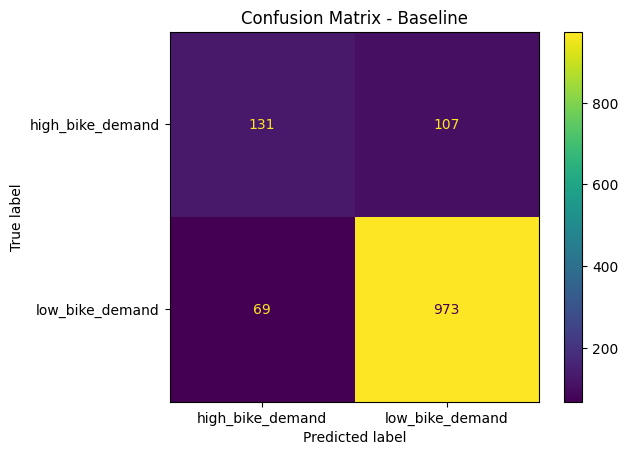


=== GRID SEARCH RESULT ===
Bästa parametrar: {'model__C': np.float64(1.0), 'model__solver': 'liblinear'}
Bästa CV-score (accuracy): 0.74765625

=== TUNED (best C + solver) ===
Accuracy: 0.74765625
Recall (high_bike_demand): 0.9033613445378151

Classification Report (Tuned):
                  precision    recall  f1-score   support

high_bike_demand       0.42      0.90      0.57       238
 low_bike_demand       0.97      0.71      0.82      1042

        accuracy                           0.75      1280
       macro avg       0.69      0.81      0.70      1280
    weighted avg       0.87      0.75      0.77      1280



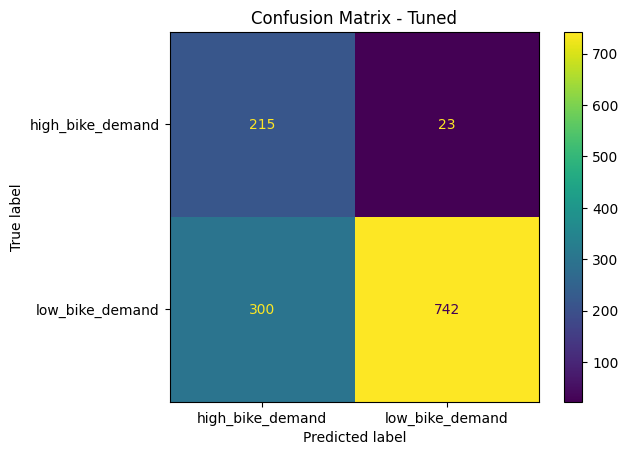

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, recall_score, accuracy_score


sys.path.append("../src")
from data_preprocessing import get_pipeline, X, y


# ============================================================
# CV
# ============================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ============================================================
# 1) BASELINE (otunad)
# ============================================================
baseline_model = LogisticRegression(
    max_iter=5000,
    random_state=42,
    class_weight={"high_bike_demand": 1, "low_bike_demand": 1}
)

baseline_pipe = get_pipeline(baseline_model)

y_pred_base = cross_val_predict(baseline_pipe, X, y, cv=cv, n_jobs=-1)

print("=== BASELINE (otunad) ===")
print("Accuracy:", accuracy_score(y, y_pred_base))
print("Recall (high_bike_demand):", recall_score(y, y_pred_base, pos_label="high_bike_demand"))
print("\nClassification Report (Baseline):")
print(classification_report(y, y_pred_base, zero_division=0))

ConfusionMatrixDisplay.from_predictions(y, y_pred_base)
plt.title("Confusion Matrix - Baseline")
plt.show()

# ============================================================
# 2) GRID SEARCH (C + solver)
# ============================================================
tune_model = LogisticRegression(
    max_iter=5000,
    random_state=42,
    class_weight={"high_bike_demand": 10, "low_bike_demand": 1}
)

tune_pipe = get_pipeline(tune_model)

param_grid = {
    "model__C": np.logspace(-4, 2, 7),
    "model__solver": ["lbfgs", "liblinear", "newton-cg", "sag", "saga"]
}

gs = GridSearchCV(
    tune_pipe,
    param_grid=param_grid,
    scoring="accuracy",   # byt till recall_high om du vill optimera recall
    cv=cv,
    n_jobs=-1,
    error_score=0,
    refit=True
)

gs.fit(X, y)

print("\n=== GRID SEARCH RESULT ===")
print("Bästa parametrar:", gs.best_params_)
print("Bästa CV-score (accuracy):", gs.best_score_)

best_pipe = gs.best_estimator_
y_pred_tuned = cross_val_predict(best_pipe, X, y, cv=cv, n_jobs=-1)

print("\n=== TUNED (best C + solver) ===")
print("Accuracy:", accuracy_score(y, y_pred_tuned))
print("Recall (high_bike_demand):", recall_score(y, y_pred_tuned, pos_label="high_bike_demand"))
print("\nClassification Report (Tuned):")
print(classification_report(y, y_pred_tuned, zero_division=0))

ConfusionMatrixDisplay.from_predictions(y, y_pred_tuned)
plt.title("Confusion Matrix - Tuned")
plt.show()


In [10]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred, labels=["low_bike_demand", "high_bike_demand"])

tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print("Accuracy:", (tp + tn) / (tp + tn + fp + fn))
print("TPR:", tpr)
print("FPR:", fpr)



NameError: name 'y_pred' is not defined